# Semantic Segmentation of Custom CVAT Field exports

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_SILENT"] = 'True'
import warnings
warnings.filterwarnings('ignore')
import random
import matplotlib.pyplot as plt
import numpy as np

import cv2
import glob
from PIL import Image
import os.path as osp
from tqdm import tqdm
from typing import Callable, List, Tuple
import torch
import catalyst
from catalyst import utils
# import wandb

In [4]:
def example(image_path = 'field2/seq/Images/300м 02.jpg', 
             mask_path ='field2/seq/Labels/300м 02.png'):
    image = Image.open(image_path)
    mask = Image.open(mask_path)    
    plt.figure(figsize=(18, 24))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
example()

FileNotFoundError: [Errno 2] No such file or directory: 'field2/seq/Images/300м 02.jpg'

# Data Preparation

We’ll need helper functions for label image conversion from 3 channel RGB color image to 1 channel label index image

In [ ]:
class UAVidColorTransformer:
    def __init__(self):
    # color table.
        self.clr_tab = self.createColorTable()
    # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab

    def createColorTable(self,dataset_name='field2'):
        if dataset_name == 'field2':
            clr_tab = {}
            clr_tab['trees'] = [241,11,122]
            clr_tab['road'] = [49,13,233]
            clr_tab['background'] = [0,0,0]
#             clr_tab['building'] = [167,98,98]
#             clr_tab['field'] = [61,245,61]
            print(clr_tab)
#         else:
#             clr_tab = {}
#             clr_tab['Clutter'] = [0, 0, 0]
#             clr_tab['Building'] = [128, 0, 0]
#             clr_tab['Road'] = [128, 64, 128]
#             clr_tab['Static_Car'] = [192, 0, 192]
#             clr_tab['Tree'] = [0, 128, 0]
#             clr_tab['Vegetation'] = [128, 128, 0]
#             clr_tab['Human'] = [64, 64, 0]
#             clr_tab['Moving_Car'] = [64, 0, 128]
        return clr_tab

    def colorTable(self):
        return self.clr_tab
   
    def clr2id(self, clr):
        return clr[0]+clr[1]*2+clr[2]*2*2

  #transform to uint8 integer label
    def transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
    # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*2+id_label[:,:,2]*2*2
        for tid,val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

  #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        print(values)
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
        return label_img

In [5]:
# lbl_path = './field2/seq/Labels/500м(2)2 19.png'
# gt = np.array(Image.open(lbl_path))
# trainId = clrEnc.transform(gt, dtype=np.uint8)
# p = clrEnc.inverse_transform(trainId)
# Image.fromarray(p)

In [6]:
clrEnc = UAVidColorTransformer()
def prepareTrainIDForDir(gtDirPath, saveDirPath):
    gt_paths = ['field2/seq']
    for pd in tqdm(gt_paths):
        lbl_dir = 'field2/seq/Labels/' #osp.join(gtDirPath, 'Labels')
        lbl_paths = os.listdir(lbl_dir)
        if not osp.isdir(osp.join(saveDirPath, pd, 'TrainId')):
            os.makedirs(osp.join(saveDirPath, pd, 'TrainId'))
            assert osp.isdir(osp.join(saveDirPath, pd, 'TrainId')), 'Fail to create directory:%s'%(osp.join(saveDirPath, pd, 'TrainId'))
        for lbl_p in lbl_paths:
            lbl_path = osp.abspath(osp.join(lbl_dir, lbl_p))
            trainId_path = osp.join(saveDirPath, pd, 'TrainId', lbl_p)
            print(lbl_path)
            gt = np.array(Image.open(lbl_path))
            trainId = clrEnc.transform(gt, dtype=np.uint8)
            Image.fromarray(trainId).save(trainId_path)

{'trees': [241, 11, 122], 'road': [49, 13, 233], 'background': [0, 0, 0]}


If we use joblib.Parallel, we can speedup ~3x

In [9]:
prepareTrainIDForDir('field2/', './trainlabels/')

  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]

/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s100040.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s92.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/00092.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s82.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s103.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s105.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s100050.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s97.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s123.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s84.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s112.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s77.png
/home/ivan/projects/chaser/drone-tiles-mapping/field2/seq/Labels/s88.png
/home/ivan/projects/chaser/drone-tile

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.04s/it]


After creating label images, we’ll define lists of images and labels for our Dataset.

In [5]:
train_image_list = sorted(glob.glob(pathname='./field2/seq/Images/*', recursive=True))
train_mask_list =  sorted(glob.glob(pathname='./trainlabels/field2/seq/TrainId/*.png', recursive=True))
print(train_image_list[2])


./field2/seq/Images/00031.jpeg


In [6]:
len(train_mask_list)== len(train_image_list)

True

In [7]:
len(train_mask_list)

108

# Dataset

Set seed and mix precision training.

In [8]:
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)
is_fp16_used = True

In our Dataset, we can read images, extract values of classes from segmentation mask, apply augmentation and pre-processing transformations.

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):

    CLASSES = ['trees', 'road',] # 'building', 'field']
    
    def __init__(
            self, 
            images_list, 
            masks_list, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_list = images_list
        self.masks_list = masks_list
        self.classes = classes
        
        # convert str names to class values on masks
        if self.classes is not None:
            self.class_values = np.array([self.CLASSES.index(cls.lower()) for cls in classes]) / 255

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        if i > len(self.masks_list):
            i = random.randint(0, len(self.masks_list))
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
            
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.astype('float') / 255
        
        # extract certain classes from mask (e.g. cars)
        if self.classes is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        else:
            mask = np.expand_dims(mask, 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

    def __len__(self):
        return len(self.images_list)

Helper functions for visualization.

In [10]:
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")
        
    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")
        
def visualize_overlay(image, mask, truth_path=None):
    if truth_path is None:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
    else:
        truth = Image.open(truth_path)
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")
        
def visualize_prediction(image, mask):
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

Visualizing segmentation masks for all classes.

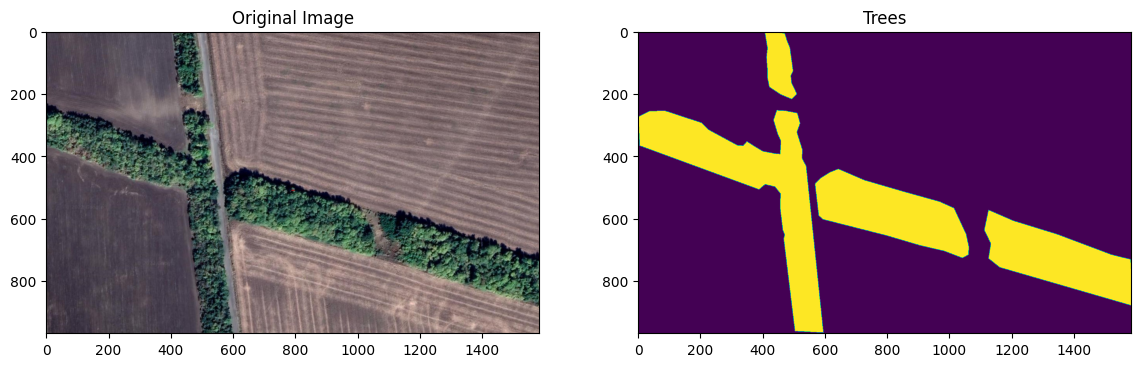

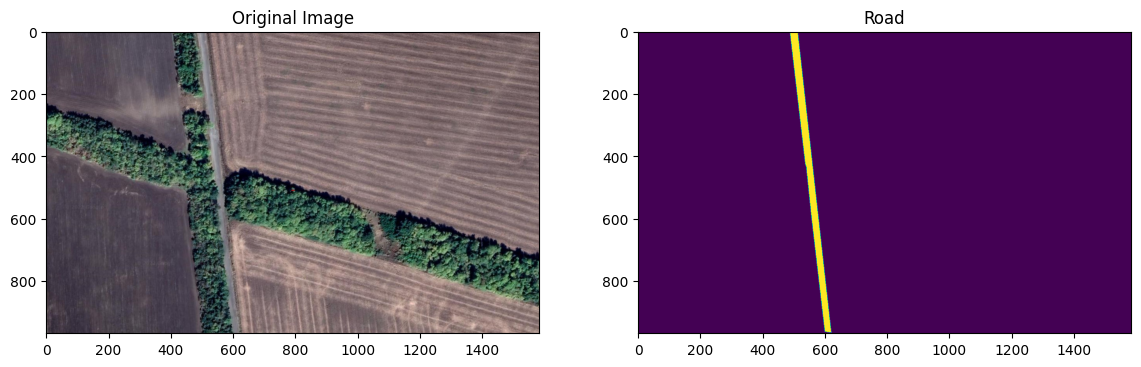

In [11]:
labels = ['trees', 'road', ] #'building', 'field']
for label in labels:
    dataset = Dataset(train_image_list, train_mask_list, classes=[label])

    image, mask = dataset[90]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label)

We'll resize images to `576*1024` to keep 9:16 ratio. 

Augmentation list:
* *HorizontalFlip*
* *OneOf(RandomBrightnessContrast, CLAHE, HueSaturationValue)*
* *IAAAdditiveGaussianNoise* with 0.2 probability

*Note:* For better result we could crop each image into 16 evenly distributed smaller(1280*720) overlapped images that cover the whole image for training.

In [12]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(p=0.5),
        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.3,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.Resize(576, 1024, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Visualizing augmented images and masks.

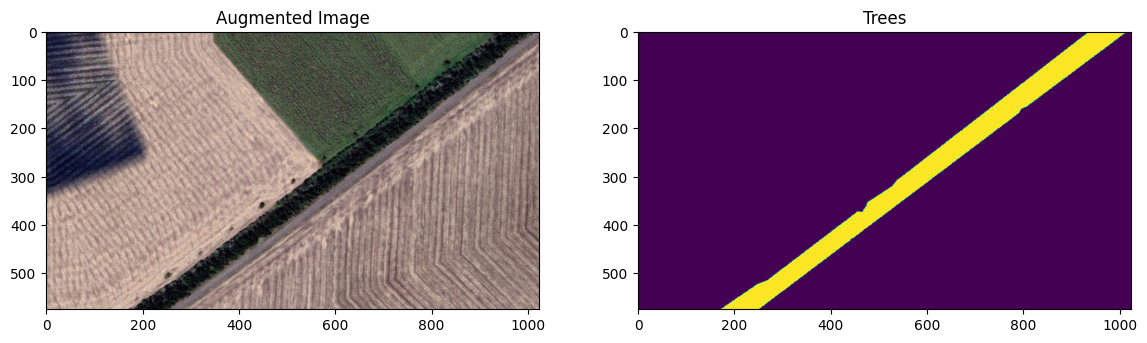

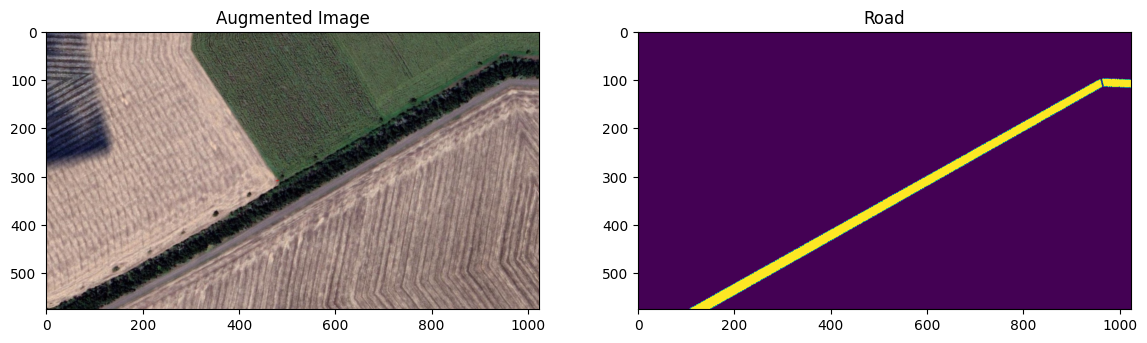

In [13]:
labels = ['trees', 'road', ] #  'building', 'field']
for label in labels:
    augmented_dataset = Dataset(
        train_image_list, 
        train_mask_list, 
        augmentation=get_training_augmentation(), 
        classes=[label],
    )

# same image with different random transforms
    image, mask = augmented_dataset[50]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label, augment=True)

# Model Creation

## Single Model

In our experiments, we'll use FPN model with EfficientnetB3 encoder. The motivation was to select best model in Memory Consumption, Accuracy trade-off.

In [14]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
CLASSES = ['trees', 'road',] # 'building', 'field']

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
# model = smp.UnetPlusPlus(
# classes=len(CLASSES), 
#     activation=ACTIVATION
# )

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

We’ll define Dataloaders and set batch size to 6, because of memory limitation.

In [16]:
batch_size = 2

train_dataset = Dataset(
    train_image_list, 
    train_mask_list, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# valid_dataset = Dataset(
#     valid_image_list, 
#     valid_mask_list, 
#     augmentation=get_validation_augmentation(), 
#     preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
# )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

loaders = {
    "train": train_loader,
#     "valid": valid_loader
}

NameError: name 'Dataset' is not defined

Selecting optimization level: **01** - Mixed Precision (recommended for typical use)

In [15]:
if is_fp16_used:
    fp16_params = dict(opt_level="O1")
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

FP16 params: {'opt_level': 'O1'}


Experiment settings:
* Loss: BCEDiceLoss with 0.5 contibution of BCE and Dice
* Optimizer: Lookahead(improves the learning stability and lowers the variance of its inner optimizer)
* Scheduler: OneCycleLRWithWarmup with 2 warmup steps
* Initial learning rate is set to 1e-3, and 1e-4 on encoder. Number of epochs to 30.

In [16]:
from catalyst.contrib.nn import BCEDiceLoss, RAdam, Lookahead, OneCycleLRWithWarmup
from catalyst.dl import SupervisedRunner

logdir = "./logs"
num_epochs = 30
learning_rate = 1e-2
base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': learning_rate}, 
    {'params': model.encoder.parameters(), 'lr': 1e-2},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
])
optimizer = Lookahead(base_optimizer)
criterion = BCEDiceLoss(activation=None)
runner = SupervisedRunner()
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.0016, 0.0000001),
    init_lr = learning_rate,
    warmup_steps=2
)

Importing callbacks for metrics and logging

In [13]:
from catalyst.dl.callbacks import IouCallback, EarlyStoppingCallback, ClasswiseIouCallback

callbacks = [
    IouCallback(activation = 'none'),
    ClasswiseIouCallback(classes=CLASSES, activation = 'none'),
    EarlyStoppingCallback(patience=7, metric='iou', minimize=False),
#     WandbLogger(project='Project_Name', name='Run_Name'),
    
]

In [17]:
torch.cuda.is_available()

False

Model training, set main_metric to **'iou'**

In [16]:
device = torch.device('cuda')
device

device(type='cuda')

In [17]:
state_dict = torch.load('model-22-03.pt')
model.load_state_dict(state_dict['model_state_dict'])

TypeError: 'FPN' object is not subscriptable

In [18]:
model = torch.load('model-22-03.pt', map_location='cpu')

In [143]:
# torch.save(model, 'model-22-03.pt')

In [20]:
state_dict.keys()

NameError: name 'state_dict' is not defined

In [127]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=20,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

Attention, there is only one data loader - train


1/20 * Epoch (train): 100% 54/54 [00:25<00:00,  2.13it/s, _timer/_fps=4.206, _timer/batch_time=0.476, _timer/data_time=0.462, _timer/model_time=0.013, iou=0.840, iou_road=0.759, iou_trees=0.876, loss=0.380]    

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f99d10372f0>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f98399ca130>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f99d10372f0>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f98399ca130>



1/20 * Epoch (train): 100% 54/54 [00:25<00:00,  2.12it/s, _timer/_fps=4.206, _timer/batch_time=0.476, _timer/data_time=0.462, _timer/model_time=0.013, iou=0.840, iou_road=0.759, iou_trees=0.876, loss=0.380]
[2023-03-22 20:31:44,138] 
1/20 * Epoch 1 (train): _timer/_fps=4.3438 | _timer/batch_time=0.4626 | _timer/data_time=0.4499 | _timer/model_time=0.0127 | iou=0.6348 | iou_road=0.6632 | iou_trees=0.4939 | loss=0.4594
[2023-03-22 20:31:44,138] 
1/20 * Epoch 1 (train): _timer/_fps=4.3438 | _timer/batch_time=0.4626 | _timer/data_time=0.4499 | _timer/model_time=0.0127 | iou=0.6348 | iou_road=0.6632 | iou_trees=0.4939 | loss=0.4594
[2023-03-22 20:31:44,138] 
1/20 * Epoch 1 (train): _timer/_fps=4.3438 | _timer/batch_time=0.4626 | _timer/data_time=0.4499 | _timer/model_time=0.0127 | iou=0.6348 | iou_road=0.6632 | iou_trees=0.4939 | loss=0.4594
[2023-03-22 20:31:44,138] 
1/20 * Epoch 1 (train): _timer/_fps=4.3438 | _timer/batch_time=0.4626 | _timer/data_time=0.4499 | _timer/model_time=0.0127 |

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f99d10372f0>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f98399ca130>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f99d10372f0>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f98399ca130>



2/20 * Epoch (train): 100% 54/54 [00:25<00:00,  2.09it/s, _timer/_fps=4.195, _timer/batch_time=0.477, _timer/data_time=0.465, _timer/model_time=0.012, iou=0.806, iou_road=0.759, iou_trees=0.826, loss=0.394]
[2023-03-22 20:32:10,655] 
2/20 * Epoch 2 (train): _timer/_fps=4.3209 | _timer/batch_time=0.4699 | _timer/data_time=0.4571 | _timer/model_time=0.0128 | iou=0.6826 | iou_road=0.6794 | iou_trees=0.6039 | loss=0.4387
[2023-03-22 20:32:10,655] 
2/20 * Epoch 2 (train): _timer/_fps=4.3209 | _timer/batch_time=0.4699 | _timer/data_time=0.4571 | _timer/model_time=0.0128 | iou=0.6826 | iou_road=0.6794 | iou_trees=0.6039 | loss=0.4387
[2023-03-22 20:32:10,655] 
2/20 * Epoch 2 (train): _timer/_fps=4.3209 | _timer/batch_time=0.4699 | _timer/data_time=0.4571 | _timer/model_time=0.0128 | iou=0.6826 | iou_road=0.6794 | iou_trees=0.6039 | loss=0.4387
[2023-03-22 20:32:10,655] 
2/20 * Epoch 2 (train): _timer/_fps=4.3209 | _timer/batch_time=0.4699 | _timer/data_time=0.4571 | _timer/model_time=0.0128 |

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f99d10372f0>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f98399ca130>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f99d10372f0>

/home/ichernu/miniconda3/envs/p37/lib/python3.7/multiprocessing/popen_fork.py:70: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f98399ca130>



                                                                                                                                                                                                             




                                 Early exiting
3/20 * Epoch (train):  17% 9/54 [00:04<00:21,  2.06it/s, _timer/_fps=4.097, _timer/batch_time=0.488, _timer/data_time=0.476, _timer/model_time=0.012, iou=0.813, iou_road=0.690, iou_trees=0.834, loss=0.386]




7/20 * Epoch (train):   0% 0/54 [03:00<?, ?it/s]

In [19]:
from torchvision import transforms
from catalyst.utils import mask_to_overlay_image
segm_transform = transforms.Compose([
#             transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
import cv2

In [20]:
model = model.eval()

In [18]:
model = model.to("cuda")

In [23]:
image = cv2.imread("tiles-20-03/jpeg/00070.jpeg") # field2/seq/Images/500м(2)2 22.jpg
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 576))

In [25]:
input_data = segm_transform(image) #['image']
input_data = input_data #.cuda()
fdata = torch.unsqueeze(input_data,0).float()
pred = model(fdata)
cls5 = pred.cpu().detach().numpy()

In [26]:
# out = cv2.cvtColor(cls5[0][1], cv2.COLOR_GRAY2BGR)
# cv2.imwrite('results/mask.jpg', cls5[0][1])

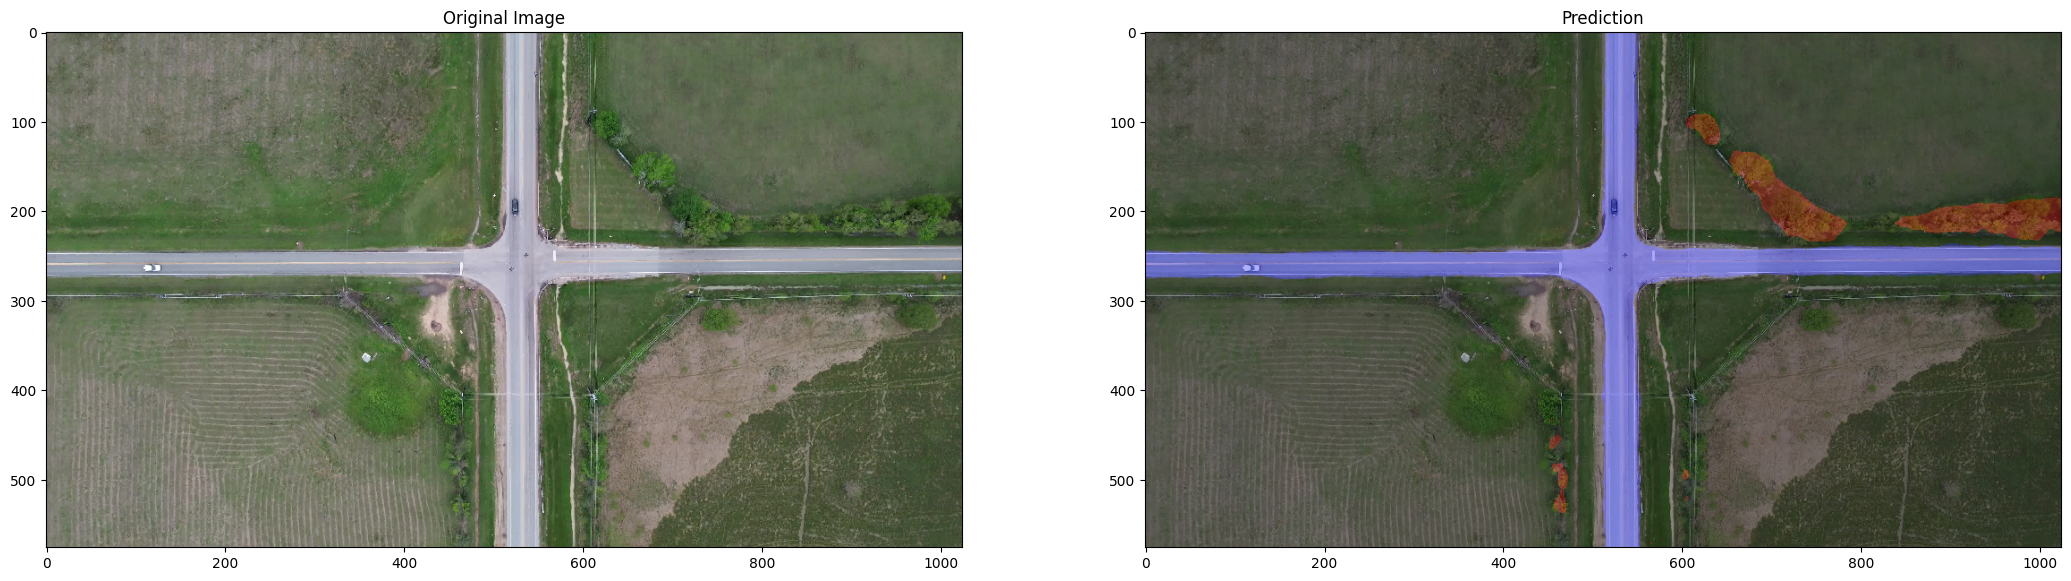

In [27]:
pred5 = mask_to_overlay_image(image=image, masks=cls5[0], threshold=0.4, mask_strength=0.3)
visualize_overlay(image, pred5, truth_path=None)

In [37]:
def run_image(img_path, result_folder, road=False, rotate=True):
    image = cv2.imread(img_path)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if rotate:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = cv2.resize(image, (1024, 576))
    input_data = segm_transform(image) #['image']
    input_data = input_data #.cuda()
    pred = model(torch.unsqueeze(input_data,0).float())
    cls5 = pred.cpu().detach().numpy()
    
    if road: 
        res = get_road_crossings_img(cls5[0][1]) 
        res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        cv2.imwrite(result_folder + f, res)
    else:
        pred5 = mask_to_overlay_image(image=image, masks=cls5[0], threshold=0.4, mask_strength=0.3)
        res = cv2.cvtColor(pred5, cv2.COLOR_BGR2RGB)
        cv2.imwrite(result_folder + f, res)

In [39]:
fold = 'tiles-20-03/jpeg/'
for f in os.listdir(fold):
    run_image(fold + f, result_folder= 'results/drone0012-jpeg/',road=False, rotate=False)

KeyboardInterrupt: 

In [37]:
fold = 'tiles-20-03/Tiles/'
for f in os.listdir(fold):
    run_image(fold + f, result_folder= 'results/cross-tiles1/',road=True, rotate=True)

/home/ichernu/miniconda3/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



crossing detected
Python int too large to convert to C long
Python int too large to convert to C long
Python int too large to convert to C long
crossing detected
Python int too large to convert to C long
crossing detected
crossing detected
Python int too large to convert to C long
crossing detected
crossing detected
crossing detected
Python int too large to convert to C long
Python int too large to convert to C long
crossing detected
crossing detected
crossing detected
crossing detected
crossing detected
crossing detected
Python int too large to convert to C long
Python int too large to convert to C long
crossing detected
crossing detected
crossing detected
crossing detected
crossing detected
Python int too large to convert to C long
crossing detected
crossing detected
crossing detected
crossing detected
crossing detected
crossing detected
Python int too large to convert to C long
crossing detected


In [35]:
! mkdir -p results/drone0012-jpeg

# Road line detection

In [30]:
import math
def get_lines(src):
    dst = cv2.Canny(src, 50, 200, None, 3)

    # Copy edges to the images that will display the results in BGR
    cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    cdstP = np.copy(cdst)

    lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

    return cdst, lines

In [31]:
def get_road_crossings_img(mask):
    x = (mask * 255).astype(np.uint8)
    vis, lines = get_lines(x)
    try:
        segmented = segment_by_angle_kmeans(lines)
        intersections = segmented_intersections(segmented)
        center = np.mean(intersections, axis=0).astype(np.int)
        vis = cv2.circle(vis, (center[0][0],center[0][1]), radius=15, color=(0, 255, 0), thickness=4)
        print('crossing detected')
    except Exception as e:
        print(e)
    return vis


In [32]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [33]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [34]:
# TAVARES and PADILHA approach
def merge_line_segments(line_i, line_j, use_log=False):    
    # line distance
    line_i_length = math.hypot(line_i[1][0] - line_i[0][0], line_i[1][1] - line_i[0][1])
    line_j_length = math.hypot(line_j[1][0] - line_j[0][0], line_j[1][1] - line_j[0][1])
    
    # centroids
    Xg = line_i_length*(line_i[0][0]+line_i[1][0]) + line_j_length*(line_j[0][0]+line_j[1][0])
    Xg /= 2 * (line_i_length + line_j_length)
    
    Yg = line_i_length*(line_i[0][1]+line_i[1][1]) + line_j_length*(line_j[0][1]+line_j[1][1])
    Yg /= 2 * (line_i_length + line_j_length)
    
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    orientation_j = math.atan2((line_j[0][1]-line_j[1][1]),(line_j[0][0]-line_j[1][0]))    
    orientation_r = math.pi
    if(abs(orientation_i - orientation_j) <= math.pi/2):
        orientation_r = line_i_length*orientation_i + line_j_length*orientation_j
        orientation_r /= line_i_length + line_j_length
    else:
        orientation_r = line_i_length*orientation_i + line_j_length*(orientation_j - math.pi*orientation_j/abs(orientation_j))
        orientation_r /= line_i_length + line_j_length
    
    # coordinate transformation
    # δXG = (δy - yG)sinθr + (δx - xG)cosθr
    # δYG = (δy - yG)cosθr - (δx - xG)sinθr
    a_x_g = (line_i[0][1] - Yg)*math.sin(orientation_r) + (line_i[0][0] - Xg) * math.cos(orientation_r)
    a_y_g = (line_i[0][1] - Yg)*math.cos(orientation_r) - (line_i[0][0] - Xg) * math.sin(orientation_r)
    
    b_x_g = (line_i[1][1] - Yg)*math.sin(orientation_r) + (line_i[1][0] - Xg) * math.cos(orientation_r)
    b_y_g = (line_i[1][1] - Yg)*math.cos(orientation_r) - (line_i[1][0] - Xg) * math.sin(orientation_r)
    
    c_x_g = (line_j[0][1] - Yg)*math.sin(orientation_r) + (line_j[0][0] - Xg) * math.cos(orientation_r)
    c_y_g = (line_j[0][1] - Yg)*math.cos(orientation_r) - (line_j[0][0] - Xg) * math.sin(orientation_r)
    
    d_x_g = (line_j[1][1] - Yg)*math.sin(orientation_r) + (line_j[1][0] - Xg) * math.cos(orientation_r)
    d_y_g = (line_j[1][1] - Yg)*math.cos(orientation_r) - (line_j[1][0] - Xg) * math.sin(orientation_r)
    
    # line distance relative
    line_i_rel_length = math.hypot(b_x_g - a_x_g, b_y_g - a_y_g)
    line_j_rel_length = math.hypot(d_x_g - c_x_g, d_y_g - c_y_g)   
    
    # orthogonal projections over the axis X
    start_f = min(a_x_g,b_x_g,c_x_g,d_x_g)
    end_f = max(a_x_g,b_x_g,c_x_g,d_x_g)
    length_f = math.hypot(end_f - start_f, 0 - 0)
    
    #start_f = line_i_rel_length * math.cos(orientation_r)
    #end_f = line_j_rel_length * math.cos(orientation_r)
    
    start_x = int(Xg - start_f * math.cos(orientation_r))
    start_y = int(Yg - start_f * math.sin(orientation_r))
    end_x = int(Xg - end_f * math.cos(orientation_r))
    end_y = int(Yg - end_f * math.sin(orientation_r))   
    
    # log process
    if(use_log):    
        print("distance between lines:", get_distance(line_i, line_j))
        print("real lines angle:", math.degrees(orientation_i), math.degrees(orientation_j))
        print("orientation angle:", math.degrees(orientation_r))
        print("centroids:", Xg, Yg)      
        print("relative lines length:", line_i_rel_length, line_j_rel_length) 
        print("real lines length:", line_i_length, line_j_length)
        print("final line length", length_f)
        print("final line endpoints", (start_x, start_y), (end_x, end_y))
        
        # Create a black image
        img = np.zeros((1400,3100,3), np.uint8)
        img = cv2.line(img, line_i[0],line_i[1],(255,0,0),5)
        img = cv2.line(img,line_j[0],line_j[1],(255,0,0),5)
        plt.imshow(img)
        plt.show()
        
        img = cv2.circle(img,(int(Xg),int(Yg)),10,(255,0,100),6)        
        img = cv2.line(img, (start_x, start_y), (end_x, end_y),(255,0,255),5)
        plt.imshow(img)
        plt.show()
    
    return [(start_x, start_y), (end_x, end_y)]